In [126]:
### IMPORT DATASET FROM CSV ###

import pandas as pd
import numpy as np

def load_raw_dataset(filename='result.csv'):
    df = pd.read_csv(filename)
    return df.reindex(np.random.RandomState(seed=42).permutation(df.index))
    
raw_dataset = load_raw_dataset()
raw_dataset.head()


,8765892,FR,ADAMSWILLER MAIRIE,485522N,071308E,8700003,FR.1,Adamswiller (Mairie),485522N.1,071308E.1,1
1433,11G0461,DE,Haltingen Im Rad Nord,473629N,073641E,1100549,DE,Haltingen Im Rad Nord,473629N,073641E,1
1558,80G0219,DE,Heilbronn Harmonie/Hafenmarktpassage,490834N,091321E,8072172,DE,Heilbronn Harmonie/Kunsthalle,490832N,091321E,0
4239,8759181,FR,Versailles-Chantiers,484747N,020808E,8739300,FR,Versailles-Chantiers,484742N,020809E,1
6001,8042210,DE,BRENK,502556N,071007E,8042210,DE,Brenk,502556N,071008E,1
1374,8002445,DE,Grüntal/Wittlensw.,482831N,082738E,8342517,IT,Guadagna,380554N,132211E,0


In [127]:
### DEFINE LEVENSTEIN METRIC ###

def call_counter(func):
    def helper(*args, **kwargs):
        helper.calls += 1
        return func(*args, **kwargs)

    helper.calls = 0
    helper.__name__ = func.__name__
    return helper


def memorize(func):
    mem = {}

    def memoizer(*args, **kwargs):
        key = str(args) + str(kwargs)
        if key not in mem:
            mem[key] = func(*args, **kwargs)
        return mem[key]

    return memoizer


@call_counter
@memorize
def levenshtein(s, t):
    if s == "":
        return len(t)
    if t == "":
        return len(s)
    if s[-1] == t[-1]:
        cost = 0
    else:
        cost = 1

    res = min([levenshtein(s[:-1], t) + 1,
               levenshtein(s, t[:-1]) + 1,
               levenshtein(s[:-1], t[:-1]) + cost])
    return res

In [128]:
### DEFINE SIMILARITY_VECTOR CLASS ###

from math import sin, cos, sqrt, atan2, radians

class SimilarityVector:
    def __init__(self):
        self.uic = 0
        self.country_similarity = 0
        self.name_distance = 0
        self.geo_distance = 0

    def set_uic(self, uic1, uic2):
        self.uic = levenshtein(str(uic1), str(uic2))

    def set_country(self, country1, country2):
        if country1 == country2:
            self.country_similarity = 1
        else:
            self.country_similarity = 0

    def set_name_distance(self, name1, name2):

        self.name_distance = levenshtein(self.__normalize_string(name1),
                                         self.__normalize_string(name2))

    def set_geo_distance(self, lat1, lon1, lat2, lon2):
        radius_earth = 6373.0
        
        
        lat1 = radians(self.__normalize_geopos(lat1))
        lon1 = radians(self.__normalize_geopos(lon1))
        lat2 = radians(self.__normalize_geopos(lat2))
        lon2 = radians(self.__normalize_geopos(lon2))

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))

        distance = radius_earth * c

        self.geo_distance = distance
        
    def __normalize_geopos(self, geopos):
           
        h = int(geopos[0:2])
        m = int(geopos[2:4])/60
        s = int(geopos[4:6])/3600
        
        res = h + m + s
               
        return res

    def __normalize_string(self, input):

        input = input.lower()
        input = ''.join(c for c in input if c not in ",-' ")

        return str(input)


In [129]:
### TRANSFORM RAW DS INTO VECTOR DS ###

dataset_x = pd.DataFrame(columns=['uic_similarity','country_similarity','name_distance','geo_distance'])
dataset_y = pd.DataFrame(columns=['match'])
for index, frame in raw_dataset.iterrows():
   
    vector = SimilarityVector()    
    vector.set_uic(frame[0],frame[5])
    vector.set_country(frame[1],frame[6])
    vector.set_name_distance(str(frame[2]),str(frame[7]))
    vector.set_geo_distance(frame[3],frame[4],frame[8],frame[9])
    
    dataset_x = dataset_x.append({
        "uic_similarity": vector.uic,
        "country_similarity": vector.country_similarity,
        "name_distance": vector.name_distance,
        "geo_distance": vector.geo_distance,
          }, ignore_index=True)
    
    dataset_y = dataset_y.append({"match": frame[10],}, ignore_index=True)

In [130]:
### REMOVE NaN, Inf, etc ###

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)


# clean_dataset(dataset_x)

dataset_x.head(8)

,uic_similarity,country_similarity,name_distance,geo_distance
0,4.0,1.0,0.0,0.000000
1,4.0,1.0,13.0,0.061794
2,4.0,1.0,0.0,0.155821
3,0.0,1.0,0.0,0.019681
4,5.0,0.0,15.0,1220.082043
5,4.0,1.0,12.0,0.040703
6,4.0,1.0,20.0,599.494908
7,5.0,1.0,11.0,35.906302


In [132]:
from sklearn.preprocessing import normalize

normalize(dataset_x, copy=False)
dataset_x.head(8)

,uic_similarity,country_similarity,name_distance,geo_distance
0,0.970143,0.242536,0.000000,0.000000
1,0.293291,0.073323,0.953196,0.004531
2,0.969450,0.242363,0.000000,0.037765
3,0.000000,0.999806,0.000000,0.019677
4,0.004098,0.000000,0.012293,0.999916
5,0.315243,0.078811,0.945728,0.003208
6,0.006668,0.001667,0.033342,0.999420
7,0.131933,0.026387,0.290252,0.947444


In [133]:
dataset_x.shape

(6562, 4)

In [134]:
dataset_y.shape

(6562, 1)

In [135]:
dataset_y.head(8)

,match
0,1
1,0
2,1
3,1
4,0
5,1
6,0
7,0


Text(0.5,0,'geo_distance')

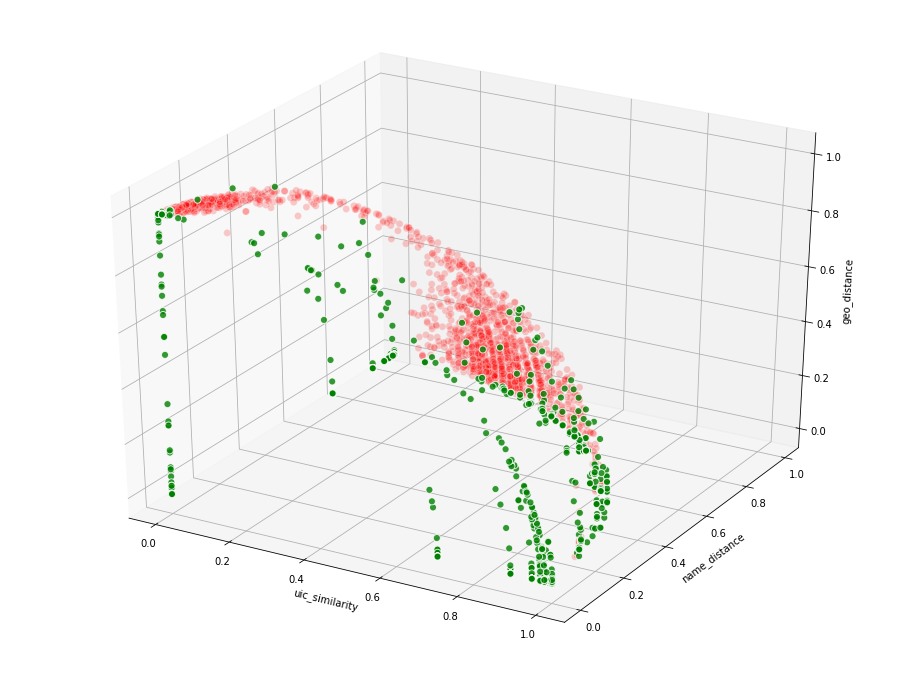

In [136]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

dataset_x_raw = dataset_x.values.tolist()

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

xs_true, ys_true, zs_true = list(), list(), list()
for i,label in dataset_y.iterrows():
    if label['match'] == 1:        
        xs_true.append(dataset_x_raw[i][0])
        ys_true.append(dataset_x_raw[i][2])
        zs_true.append(dataset_x_raw[i][3])
        
ax.scatter(xs_true, ys_true, zs_true, s=50, alpha=0.8, edgecolors='w', color="g")

xs_false, ys_false, zs_false = list(), list(), list()
for i,label in dataset_y.iterrows():
    if label['match'] == 0:        
        xs_false.append(dataset_x_raw[i][0])
        ys_false.append(dataset_x_raw[i][2])
        zs_false.append(dataset_x_raw[i][3])
        
ax.scatter(xs_false, ys_false, zs_false, s=50, alpha=0.2, edgecolors='w', color="r")

ax.set_xlabel('uic_similarity')
ax.set_ylabel('name_distance')
ax.set_zlabel('geo_distance')

# ax.set_xlim([0, 2])
# ax.set_ylim([0, 1])
# ax.set_zlim([0, 1])

Text(0,0.5,'match/no match')

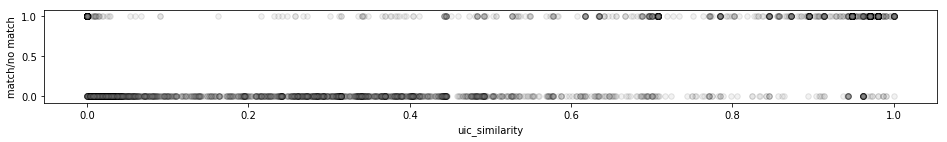

In [137]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(611)

xs_true, ys_true, = list(), list()
for i,label in dataset_y.iterrows():
    xs_true.append(dataset_x_raw[i][0])
    ys_true.append(label['match'])
        
ax.scatter(xs_true, ys_true, s=30, alpha=0.1, edgecolors='black', color="gray")

ax.set_xlabel('uic_similarity')
ax.set_ylabel('match/no match')


Text(0,0.5,'match/no match')

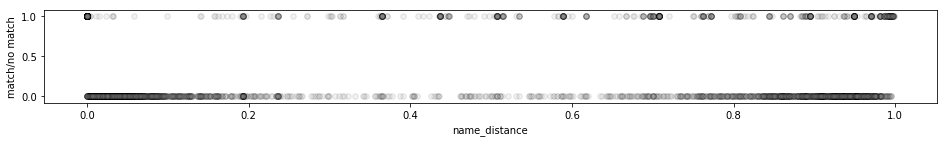

In [138]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(611)

xs_true, ys_true, zs_true = list(), list(), list()
for i,label in dataset_y.iterrows():
    xs_true.append(dataset_x_raw[i][2])
    ys_true.append(label['match'])
        
ax.scatter(xs_true, ys_true, s=30, alpha=0.1, edgecolors='black', color="gray")

ax.set_xlabel('name_distance')
ax.set_ylabel('match/no match')


Text(0,0.5,'match/no match')

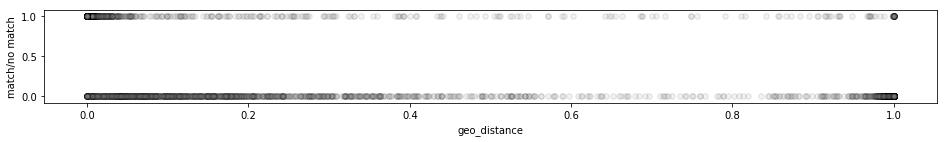

In [139]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(611)

xs_true, ys_true, zs_true = list(), list(), list()
for i,label in dataset_y.iterrows():
    xs_true.append(dataset_x_raw[i][3])
    ys_true.append(label['match'])
        
ax.scatter(xs_true, ys_true, s=30, alpha=0.1, edgecolors='black', color="gray")

ax.set_xlabel('geo_distance')
ax.set_ylabel('match/no match')


In [140]:
# SPLIT DATASET TEST/TRAIN ###

div = 5000

X_train, X_test, y_train, y_test = dataset_x[:div], dataset_x[div:],dataset_y[:div], dataset_y[div:]
y_train=y_train.astype('int')

In [141]:
### ............................ ###
###                              ###
### SGDClassifier and estimation ###
###                              ###
### ............................ ###

In [142]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train.values.ravel())

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [143]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train.values.ravel(), cv=3, scoring="roc_auc")

array([0.98390779, 0.98629554, 0.98699744])

In [144]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train.values.ravel(), cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)

array([[2349,  127],
       [ 159, 2365]], dtype=int64)

In [145]:
### DEFINE PRETTY PRINT CONFUSIN MATRIX ###
import seaborn as sns

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(16,8), title="TITLE"):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title, fontdict={'fontsize':20})
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, annot_kws={"size": 16})

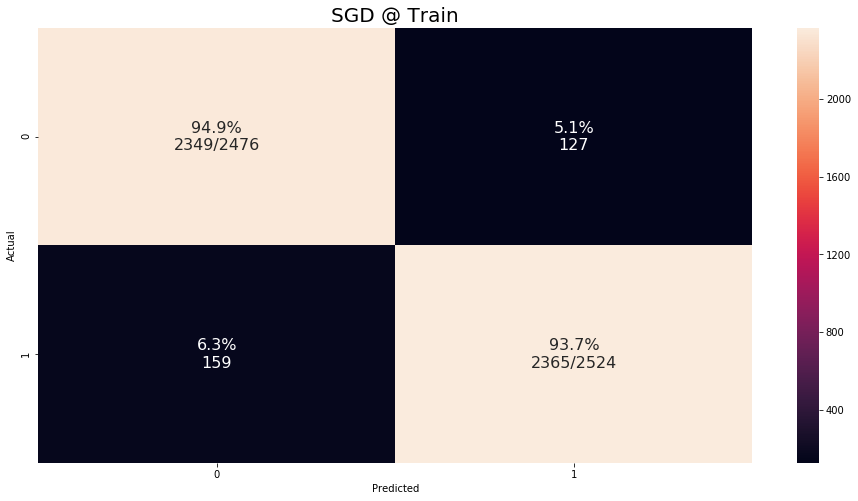

In [146]:
cm_analysis(y_train.astype('int'), y_train_pred, sgd_clf.classes_, title="SGD @ Train")

In [147]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train, y_train_pred)

0.9490369181380417

In [148]:
recall_score(y_train, y_train_pred)

0.9370047543581617

In [149]:
from sklearn.metrics import f1_score
f1_score(y_train, y_train_pred)

0.9429824561403509

In [150]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train.values.ravel(), cv=3,
                             method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

y_scores.shape

(5000,)

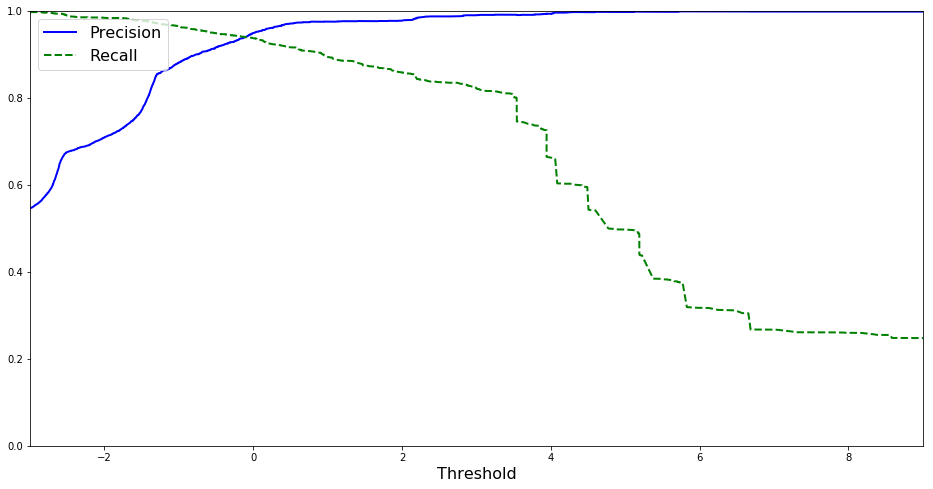

In [151]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b-", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])
    
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    
plt.figure(figsize=(16, 8))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-3, 9])

plt.show()

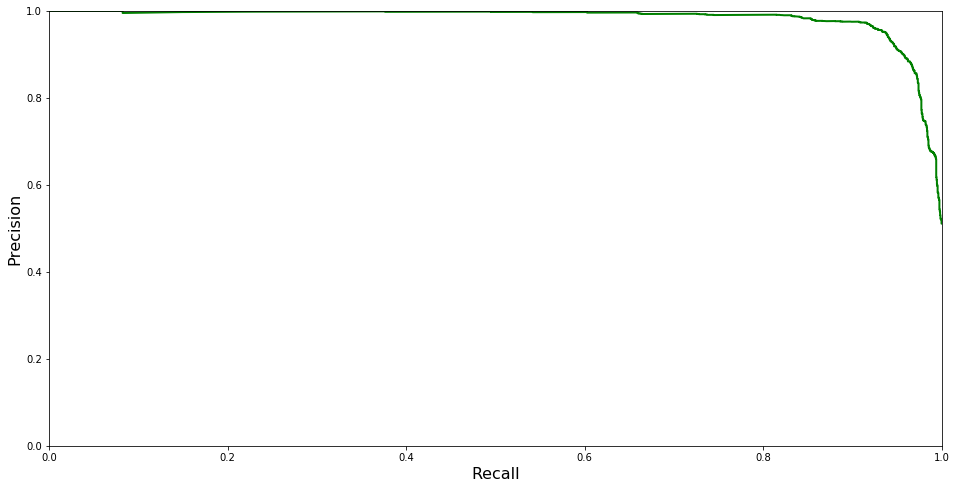

In [152]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "g-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(16, 8))
plot_precision_vs_recall(precisions, recalls)
plt.show()

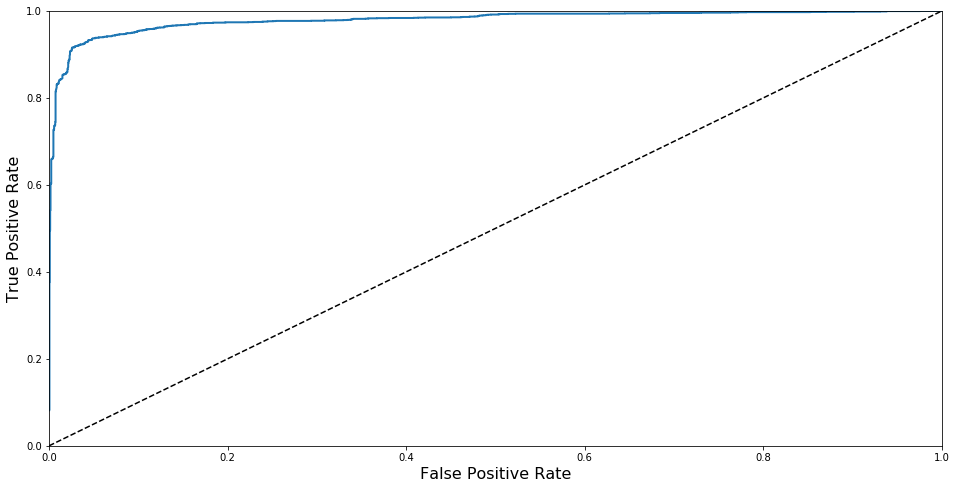

In [153]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(16, 8))
plot_roc_curve(fpr, tpr)
plt.show()

In [154]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train, y_scores)

0.9790273471603145

In [155]:
from sklearn.model_selection import GridSearchCV

param_grid={'alpha': [0.0001,0.001,0.01,0.1], 'epsilon': [0.01,0.1,1],'l1_ratio': [0.01,0.1,0.03,1],'max_iter':[5, 50, 500]}
 
clf = SGDClassifier()

grid_search = GridSearchCV(clf, param_grid, cv=5, verbose=3, n_jobs=12, scoring="roc_auc")
grid_search.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:   10.4s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:   16.3s
[Parallel(n_jobs=12)]: Done 264 tasks      | elapsed:   19.0s
[Parallel(n_jobs=12)]: Done 488 tasks      | elapsed:   23.0s
[Parallel(n_jobs=12)]: Done 720 out of 720 | elapsed:   27.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=12,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1], 'epsilon': [0.01, 0.1, 1], 'l1_ratio': [0.01, 0.1, 0.03, 1], 'max_iter': [5, 50, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=3)

In [156]:
grid_search.best_score_

0.9879694278915218

In [157]:
grid_search.best_params_

{'alpha': 0.001, 'epsilon': 0.01, 'l1_ratio': 1, 'max_iter': 50}

In [158]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(alpha = 0.001, epsilon = 0.01, l1_ratio = 1, max_iter = 50, random_state=42)
sgd_clf.fit(X_train, y_train.values.ravel())

SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.01,
       eta0=0.0, fit_intercept=True, l1_ratio=1, learning_rate='optimal',
       loss='hinge', max_iter=50, n_iter=None, n_jobs=1, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None, verbose=0,
       warm_start=False)

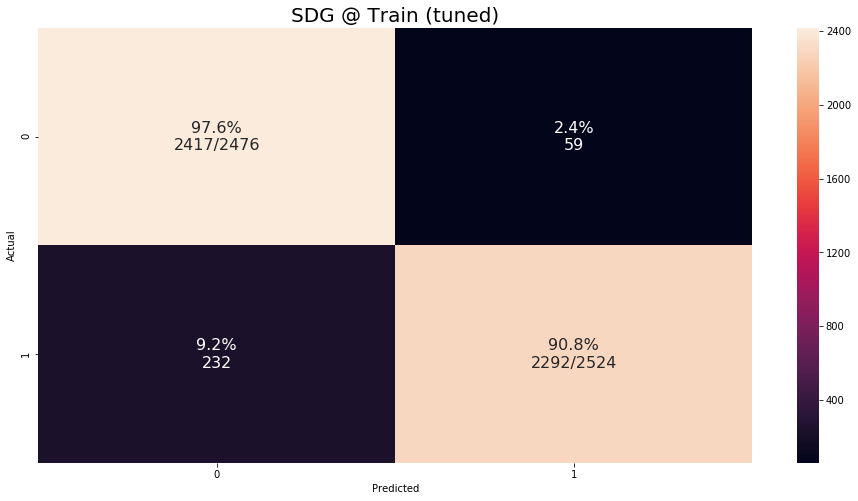

In [159]:
y_train_pred = sgd_clf.predict(X_train).astype('int')

cm_analysis(y_train.astype('int'), y_train_pred, sgd_clf.classes_, title="SDG @ Train (tuned)")

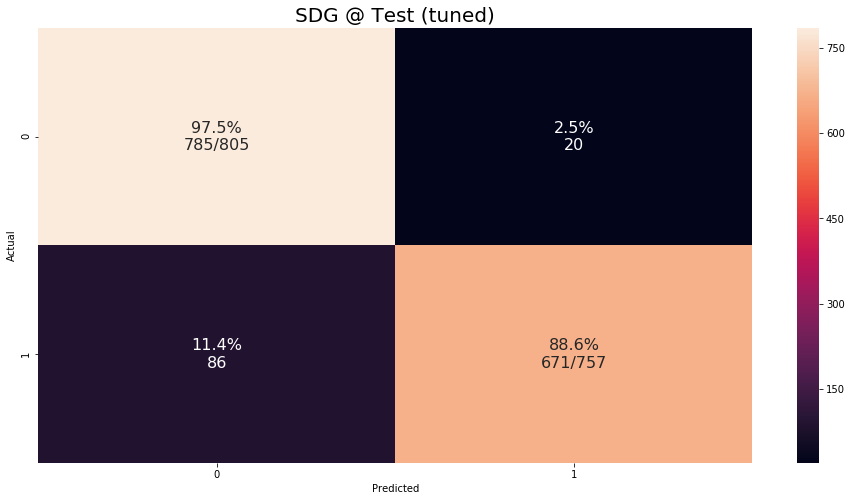

In [171]:
y_test_pred = sgd_clf.predict(X_test).astype('int')

cm_analysis(y_test.astype('int'), y_test_pred, sgd_clf.classes_, title="SDG @ Test (tuned)")

In [160]:
### ...................... ###
###                        ###
### RandomForestClassifier ###
###                        ###
### ...................... ###

In [218]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=8, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train.values.ravel(), cv=3,
                                    method="predict_proba")
forest_clf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=8, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

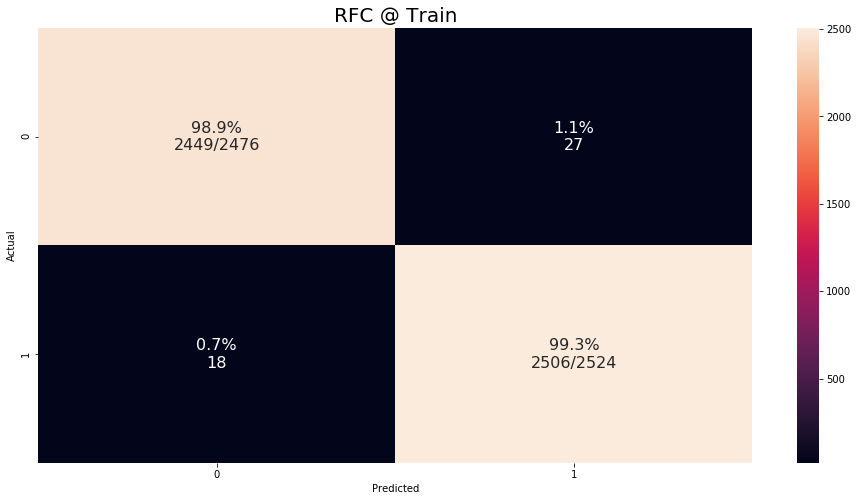

In [219]:
y_train_pred = forest_clf.predict(X_train).astype('int')

cm_analysis(y_train.astype('int'), y_train_pred, forest_clf.classes_, title="RFC @ Train")

In [220]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_scores_forest)

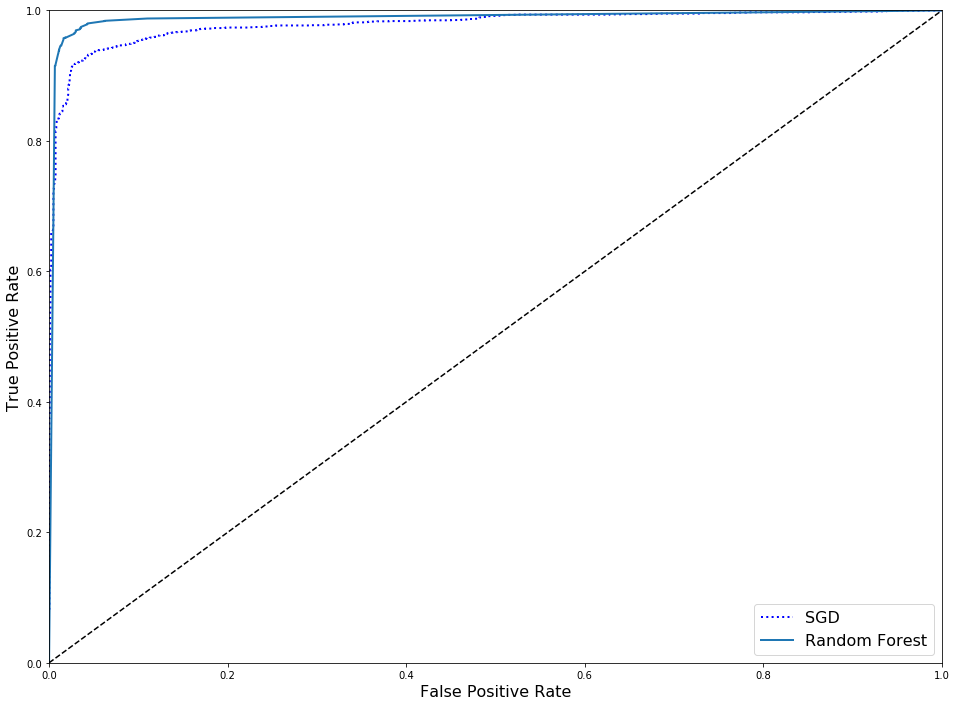

In [221]:
plt.figure(figsize=(16, 12))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)

plt.show()

In [222]:
roc_auc_score(y_train, y_scores_forest)

0.9885043005563391

In [223]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train.values.ravel(), cv=3)
precision_score(y_train, y_train_pred_forest)

0.970646568821896

In [224]:
recall_score(y_train, y_train_pred_forest)

0.9694928684627575

In [228]:
from sklearn.model_selection import GridSearchCV

param_grid={'n_estimators': [2, 4, 8, 20, 50, 100],
            'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth': [4, 5, 6, 7, 8],
            'min_samples_leaf': [1,2,4,10,20],
            'min_samples_split': [0.1,2,4,10,20],
            'criterion': ['gini', 'entropy']},
clf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(clf, param_grid, cv=5, verbose=3, n_jobs=12, scoring="roc_auc")
grid_search.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 4500 candidates, totalling 22500 fits


[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:   10.2s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:   17.0s
[Parallel(n_jobs=12)]: Done 264 tasks      | elapsed:   21.4s
[Parallel(n_jobs=12)]: Done 488 tasks      | elapsed:   27.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:   34.9s
[Parallel(n_jobs=12)]: Done 1128 tasks      | elapsed:   44.3s
[Parallel(n_jobs=12)]: Done 1544 tasks      | elapsed:   54.9s
[Parallel(n_jobs=12)]: Done 2024 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done 2568 tasks      | elapsed:  1.4min
[Parallel(n_jobs=12)]: Done 3176 tasks      | elapsed:  1.7min
[Parallel(n_jobs=12)]: Done 3848 tasks      | elapsed:  2.0min
[Parallel(n_jobs=12)]: Done 4584 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 5384 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 6248 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 7176 tasks      | elapsed:  3.7min
[Parallel(n_jobs=12)]: Done 8168 tasks      | elapsed:  4.2m

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=12,
       param_grid=({'n_estimators': [2, 4, 8, 20, 50, 100], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [4, 5, 6, 7, 8], 'min_samples_leaf': [1, 2, 4, 10, 20], 'min_samples_split': [0.1, 2, 4, 10, 20], 'criterion': ['gini', 'entropy']},),
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=3)

In [233]:
grid_search.best_score_

0.9960169085197691

In [229]:
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 20,
 'n_estimators': 100}

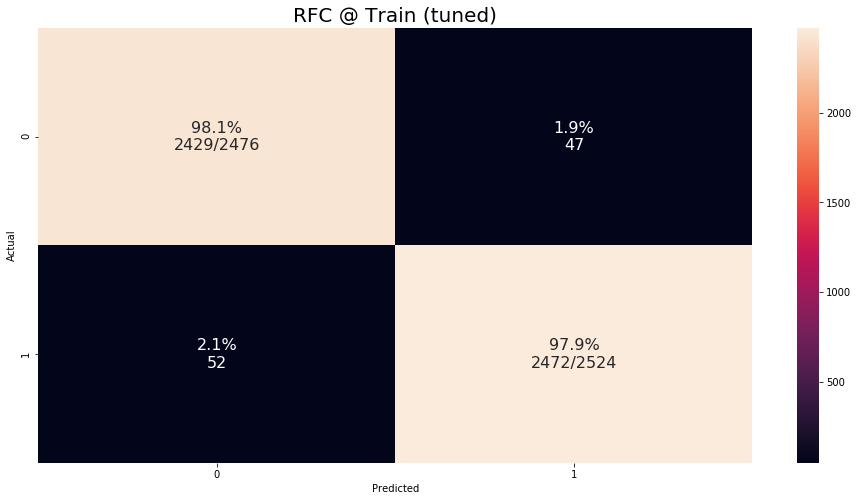

In [237]:
forest_clf = RandomForestClassifier(n_estimators=100, max_depth=6,
                                    min_samples_leaf = 4,
                                    min_samples_split = 20,
                                    max_features = 'auto', criterion = 'entropy', random_state=42)

forest_clf.fit(X_train, y_train.values.ravel())

y_train_pred = forest_clf.predict(X_train).astype('int')

cm_analysis(y_train.astype('int'), y_train_pred, forest_clf.classes_, title="RFC @ Train (tuned)")

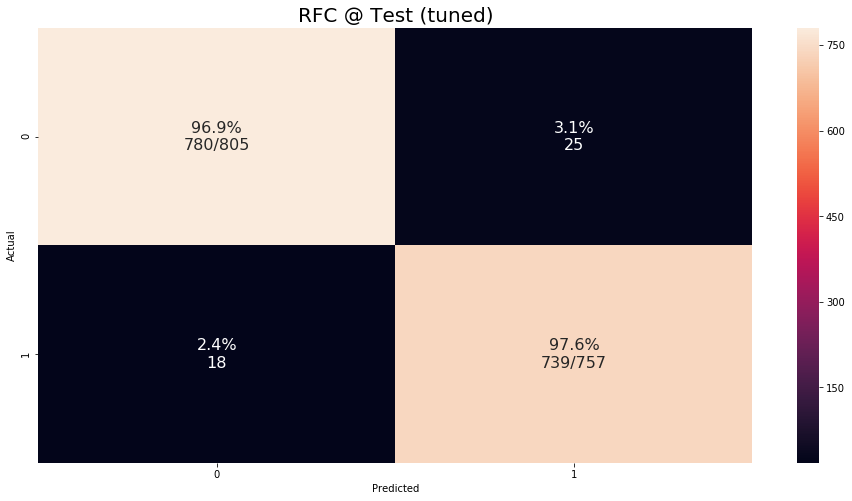

In [236]:
y_test_pred = forest_clf.predict(X_test).astype('int')

cm_analysis(y_test.astype('int'), y_test_pred, forest_clf.classes_, title="RFC @ Test (tuned)")

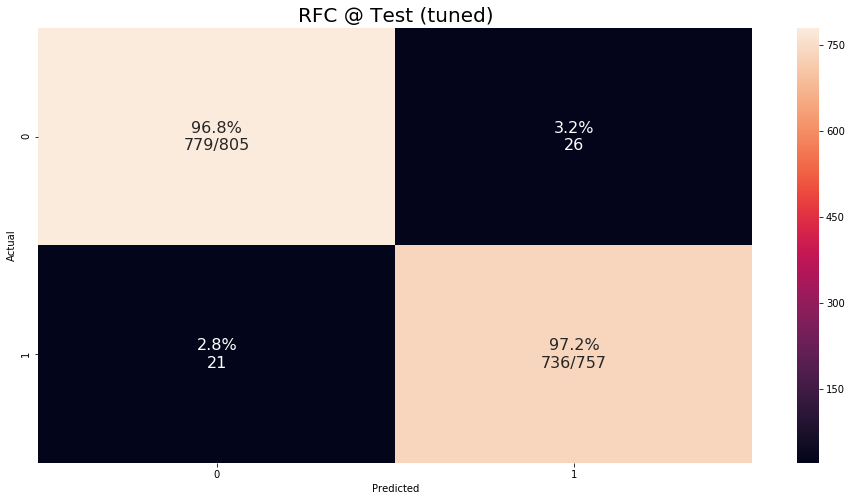

In [238]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=8, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train.values.ravel(), cv=3,
                                    method="predict_proba")
forest_clf.fit(X_train, y_train.values.ravel())

y_test_pred = forest_clf.predict(X_test).astype('int')

cm_analysis(y_test.astype('int'), y_test_pred, forest_clf.classes_, title="RFC @ Test (tuned)")

In [239]:
### .............. ###
###                ###
### SVM Classifier ###
###                ###
### .............. ###


In [240]:
from sklearn.svm import SVC
svm_clf = SVC(kernel="linear", C=100, probability=True, random_state=42)
svm_clf.fit(X_train, y_train.values.ravel())

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

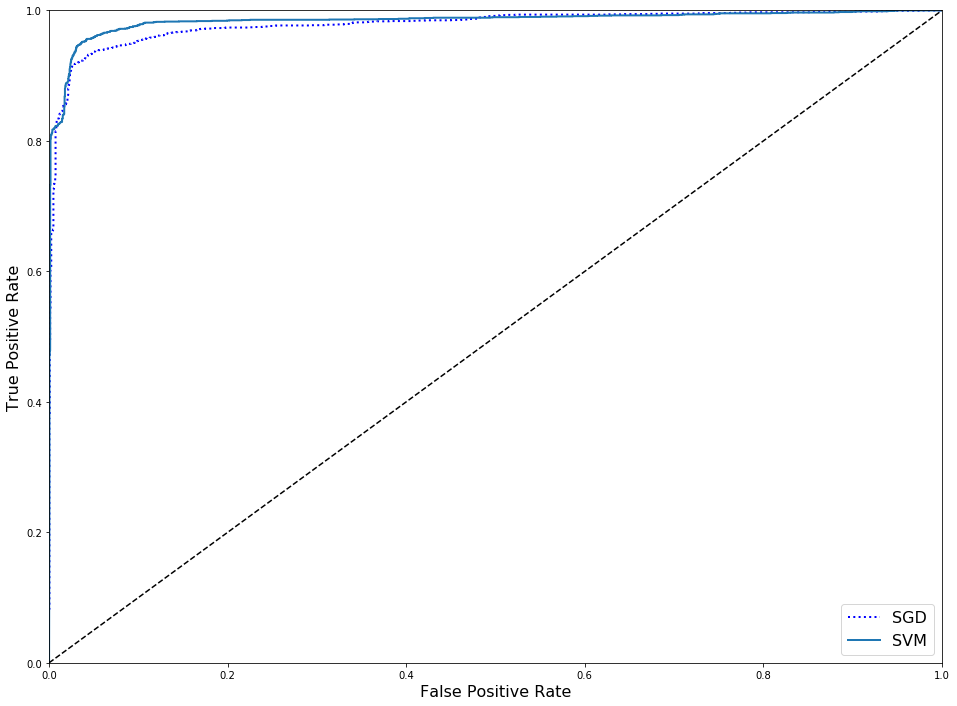

In [241]:
y_probas_svm = cross_val_predict(svm_clf, X_train, y_train.values.ravel(), cv=3,
                                    method="predict_proba")

y_scores_svm = y_probas_svm[:, 1] # score = proba of positive class

fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_train, y_scores_svm)

plt.figure(figsize=(16, 12))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_svm, tpr_svm, "SVM")
plt.legend(loc="lower right", fontsize=16)

plt.show()

In [242]:
y_probas_svm = cross_val_predict(svm_clf, X_train, y_train.values.ravel(), cv=3,
                                    method="predict_proba")
y_scores_svm = y_probas_svm[:, 1] # score = proba of positive class
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_train, y_scores_svm)


roc_auc_score(y_train, y_scores_forest)

0.9885043005563391

In [243]:
y_train_pred_svm = cross_val_predict(svm_clf, X_train, y_train.values.ravel(), cv=3)
precision_score(y_train, y_train_pred_svm)

0.9741343345848978

In [244]:
recall_score(y_train, y_train_pred_svm)

0.9251188589540412

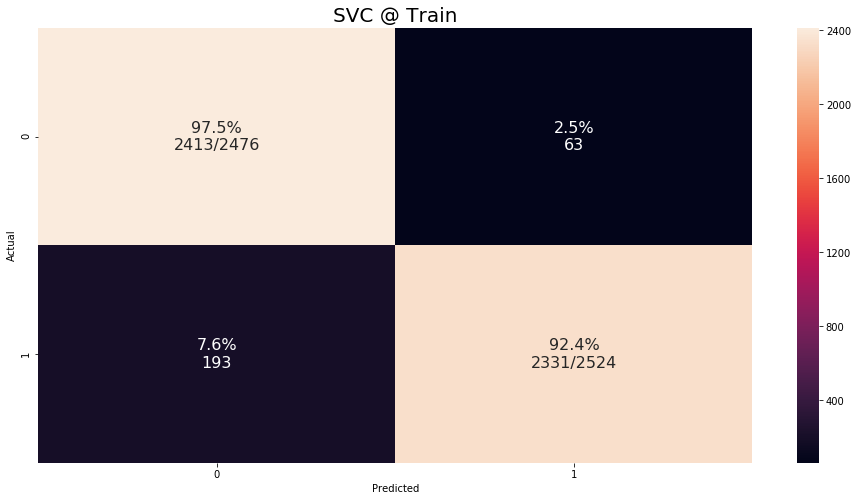

In [245]:
svm_clf.fit(X_train, y_train.values.ravel())

y_train_pred = svm_clf.predict(X_train).astype('int')

cm_analysis(y_train.astype('int'), y_train_pred, svm_clf.classes_, title="SVC @ Train")

In [248]:
param_grid = {'C':[10, 100, 200, 500, 1000, 3000, 5000],'gamma':[0.1,1,3,7,10], 'kernel':['linear','rbf']}
clf = SVC(random_state=42)

grid_search = GridSearchCV(clf, param_grid, cv=5, verbose=3, n_jobs=8, scoring="roc_auc")
grid_search.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    9.6s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   13.1s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   30.3s
[Parallel(n_jobs=8)]: Done 350 out of 350 | elapsed:  1.0min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'C': [10, 100, 200, 500, 1000, 3000, 5000], 'gamma': [0.1, 1, 3, 7, 10], 'kernel': ['linear', 'rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=3)

In [249]:
grid_search.best_params_

{'C': 1000, 'gamma': 3, 'kernel': 'rbf'}

In [250]:
grid_search.best_score_

0.9883313545611473

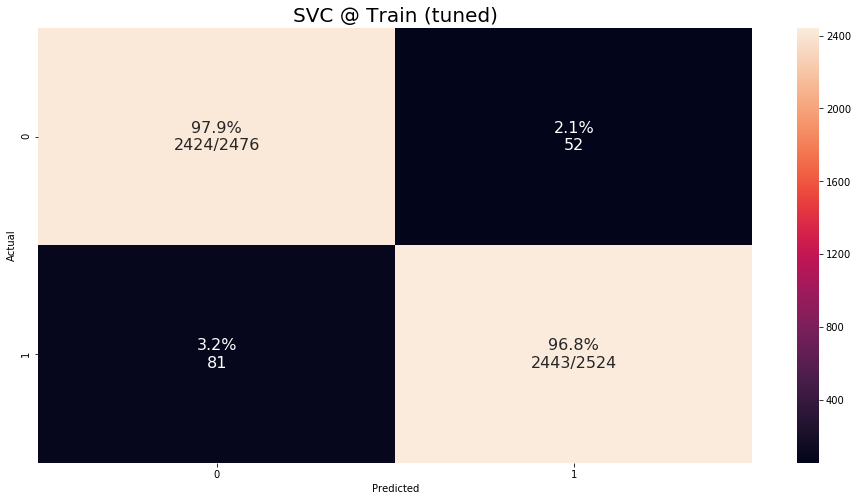

In [251]:
svm_clf = SVC(kernel="rbf", C=1000, gamma=3, probability=True)

svm_clf.fit(X_train, y_train.values.ravel())

y_train_pred = svm_clf.predict(X_train).astype('int')

cm_analysis(y_train.astype('int'), y_train_pred, svm_clf.classes_, title="SVC @ Train (tuned)")

In [252]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from sklearn.metrics import make_scorer, roc_auc_score

mdl = SVC(probability = True, random_state = 42, kernel="rbf")

rand_list = {"C": stats.uniform(600, 1200),
             "gamma": stats.uniform(2, 10)}
              
rand_search = RandomizedSearchCV(mdl, param_distributions = rand_list, n_iter = 20,
                                 n_jobs = 8, verbose=6, cv = 3, random_state = 42, scoring = 'roc_auc')

rand_search.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   23.9s
[Parallel(n_jobs=8)]: Done  56 out of  60 | elapsed:   33.8s remaining:    2.3s
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:   36.7s finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=8,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024D778592E8>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024D77859438>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=6)

In [253]:
rand_search.best_params_

{'C': 1310.897482634451, 'gamma': 2.4645041271999775}

In [254]:
rand_search.best_score_

0.9887382818422604

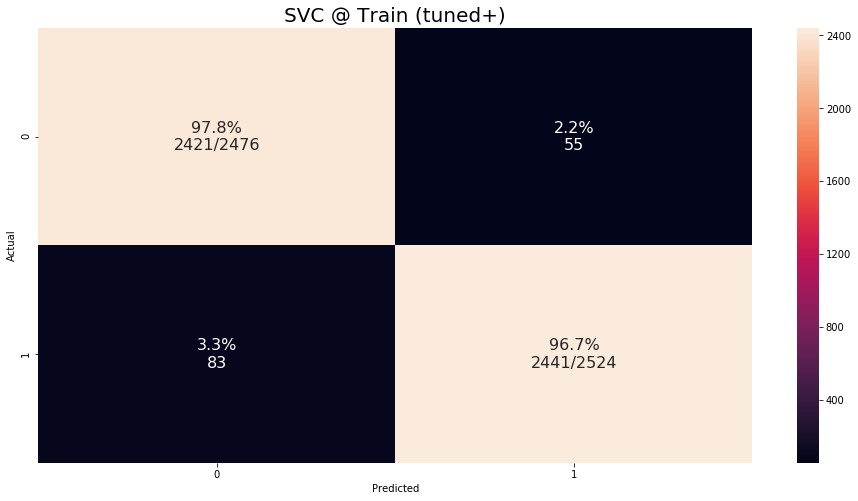

In [257]:
svm_clf = SVC(kernel="rbf", C=1310.89, gamma=2.464, random_state=42, probability=True)

svm_clf.fit(X_train, y_train.values.ravel())

y_train_pred = svm_clf.predict(X_train).astype('int')

cm_analysis(y_train.astype('int'), y_train_pred, svm_clf.classes_, title="SVC @ Train (tuned+)")

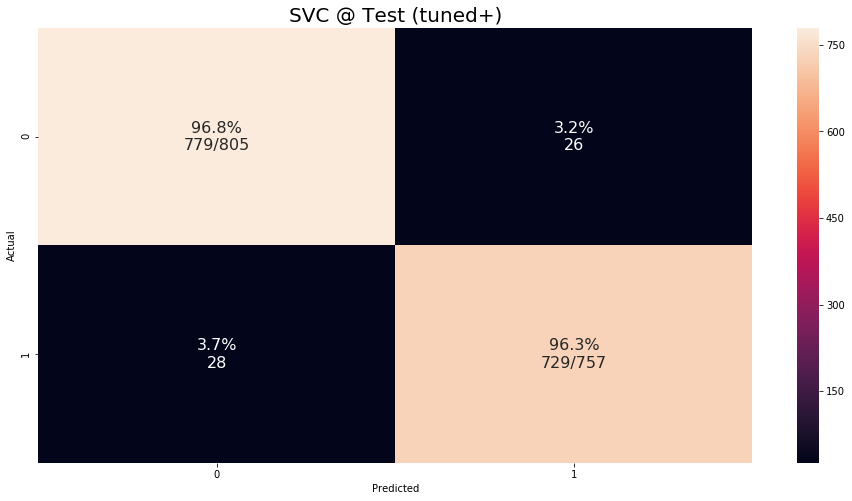

In [258]:
y_test_pred = svm_clf.predict(X_test).astype('int')

cm_analysis(y_test.astype('int'), y_test_pred, svm_clf.classes_, title="SVC @ Test (tuned+)")

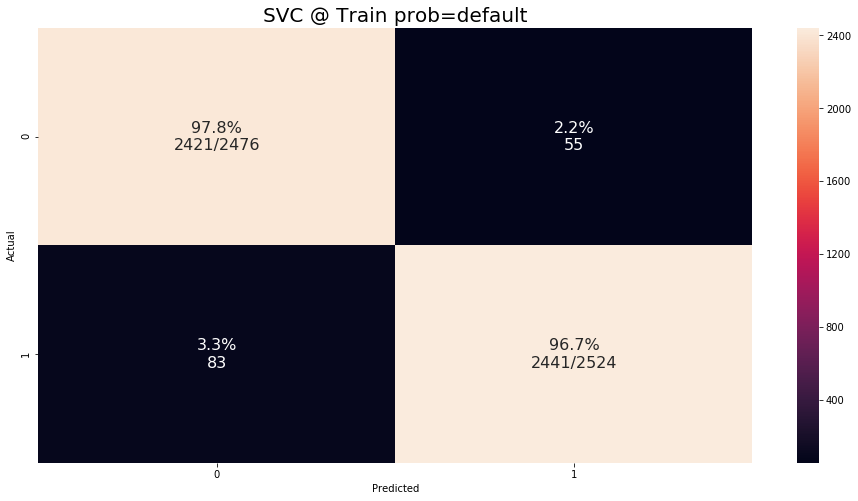

In [265]:
### Tune by PROB ###

y_train_pred = svm_clf.predict(X_train).astype('int')

cm_analysis(y_train.astype('int'), y_train_pred, svm_clf.classes_, title="SVC @ Train prob=default")

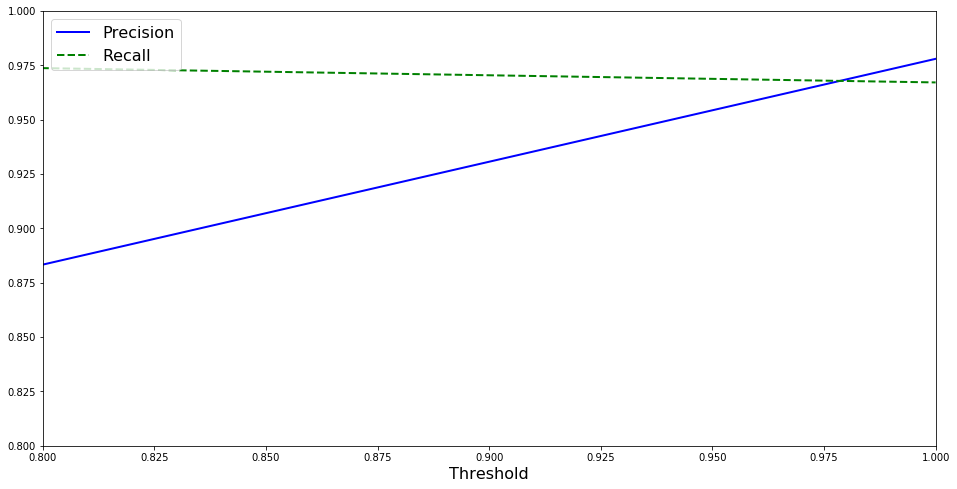

In [260]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_pred)

plt.figure(figsize=(16, 8))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([0.8, 1])
plt.ylim([0.8, 1])

plt.show()

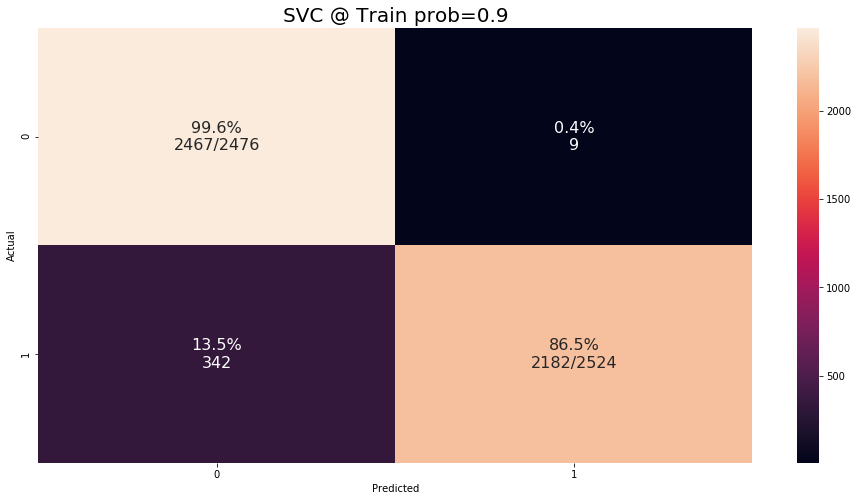

In [287]:
### PROB PREDICTION ###

y_train_pred = (svm_clf.predict_proba(X_train)[:,1] >= 0.96).astype(int)

cm_analysis(y_train.astype('int'), y_train_pred, svm_clf.classes_, title="SVC @ Train prob=0.96")

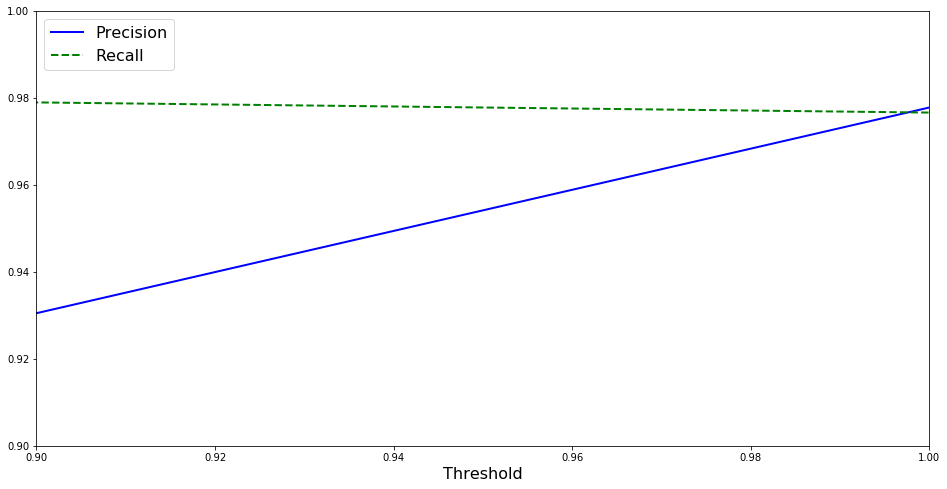

In [272]:
forest_clf.fit(X_train, y_train.values.ravel())

y_train_pred = forest_clf.predict(X_train).astype('int')

precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_pred)


plt.figure(figsize=(16, 8))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([0.9, 1])
plt.ylim([0.9, 1])

plt.show()

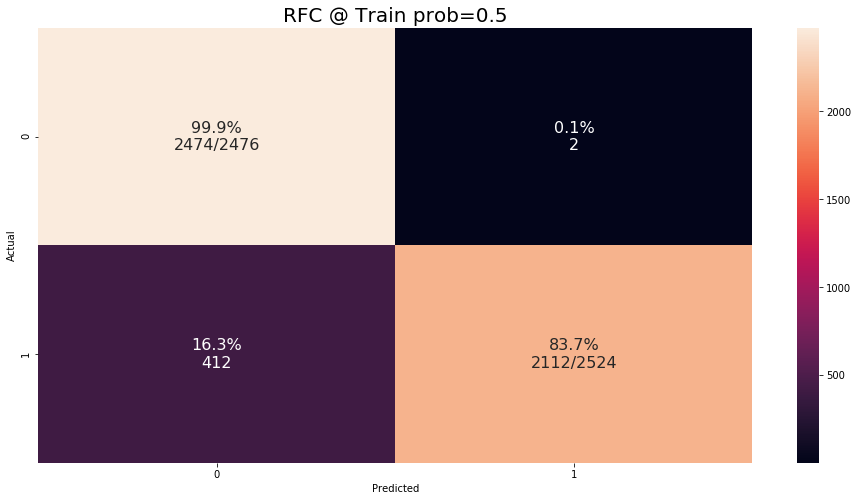

In [283]:
y_train_pred = (forest_clf.predict_proba(X_train)[:,1] >= 0.95).astype(int)

cm_analysis(y_train.astype('int'), y_train_pred, forest_clf.classes_, title="RFC @ Train prob=0.95")

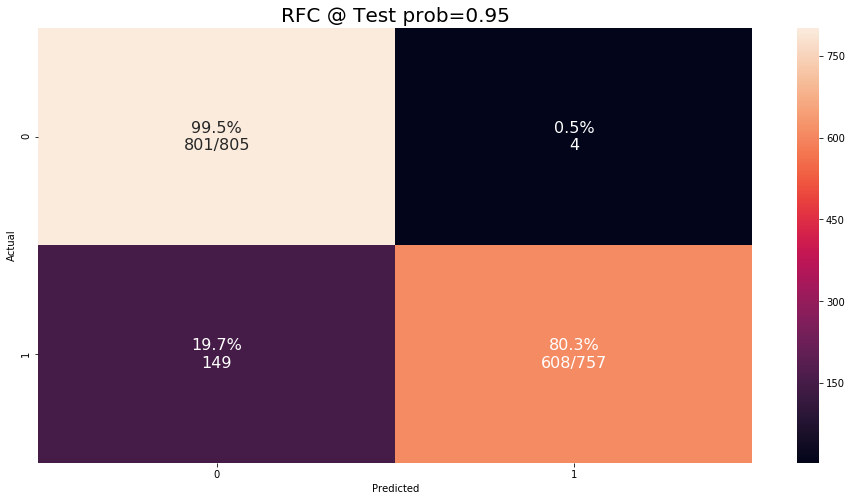

In [288]:
y_test_pred = (forest_clf.predict_proba(X_test)[:,1] >= 0.95).astype(int)

cm_analysis(y_test.astype('int'), y_test_pred, forest_clf.classes_, title="RFC @ Test prob=0.95")